<div style="background-color:gray; padding:15px; border-radius:10px; font-size:20px; color:white;">
    <h2 style="margin-bottom:10px;">LGBM 모델 사용학습 목차</h2>
    <ol style="padding-left:20px;">
        <li>(시도 1) 수동 결측치 처리 및 인코딩 데이터 프레임으로 학습</li>
        <li>(시도 2) 결측치 'missing' 텍스트 처리</li>
        <li>(시도 3) 임의로 선택한 하이퍼 파라미터로 예측</li>
        <li>(시도 4) 임의로 선택한 하이퍼 파라미터로 예측 2</li>
        <li>(시도 5) 모든 변수 타겟인코딩</li>
        <li>(시도 6) 인덱스 제거 후 학습</li>
    </ol>
</div>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import time
from tqdm import tqdm
import optuna

from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 데이터 로드
ce_train_df5 = pd.read_csv('ce_train_df5')
ce_test_df5 = pd.read_csv('ce_test_df5')
y_df = pd.read_csv('y_df')
sub = pd.read_csv('sample_submission.csv')

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(LGBM 시도 1)<br>
결측치 'Missing' 처리<br>
범주형 변수 원-핫 인코딩 처리<br>
</div>

In [8]:
%%time

# 인덱스 초기화
ce_train_df5 = ce_train_df5.reset_index(drop = True)
ce_test_df5 = ce_test_df5.reset_index(drop = True)

# 로그 출력 최소화
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 목표함수 정의
def objective(trial):

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'random_state': 1,
        'device': 'gpu', 
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'verbose': -1
    }

    # 트리 개수 지정 (조기 종료 기능을 위해)
    num_boost_round = trial.suggest_int("num_boost_round", 100, 1500)
    
    # 평가척도
    rmse_scores = []

    # 교차검증 객체 생성
    kf = KFold(n_splits = 5, shuffle = True, random_state = 1)

    for train_index, val_index in kf.split(ce_train_df5):
        
        # 학습,검증 데이터 분할
        x_train, x_val = ce_train_df5.iloc[train_index], ce_train_df5.iloc[val_index]
        y_train, y_val = y_df.iloc[train_index], y_df.iloc[val_index]

        lgbm_model = LGBMRegressor(**params, early_stopping_rounds=100)
        lgbm_model.fit(x_train, y_train, eval_set=[(x_val, y_val)])
        y_pred = lgbm_model.predict(x_val)

        rmse = root_mean_squared_error(y_val, y_pred)
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)
    
n_trials = 100
lgbm_study = optuna.create_study(direction = 'minimize')
lgbm_study.optimize(objective, n_trials=n_trials, catch=(Exception,))

        
# 최적 결과 출력
print("\n최고의 RMSE값:", lgbm_study.best_value)
print("최고의 하이퍼파라미터:", lgbm_study.best_params)


최고의 RMSE값: 38.8696022885128
최고의 하이퍼파라미터: {'learning_rate': 0.07515611287234839, 'max_depth': 14, 'num_leaves': 148, 'min_child_samples': 29, 'subsample': 0.9698975145499753, 'colsample_bytree': 0.8563004141958307, 'reg_alpha': 5.808500513974364, 'reg_lambda': 3.301304226017915, 'num_boost_round': 1022}
CPU times: total: 9h 54min
Wall time: 1h 47min 23s


Feature Importances:
                       Feature  Importance
1         Weight Capacity (kg)       28142
0                 Compartments       25427
2                Missing_count        5228
22               Waterproof_No        4100
19       Laptop Compartment_No        3961
23              Waterproof_Yes        3910
27                  Style_Tote        3902
15                 Size_Medium        3844
14                  Size_Large        3786
20      Laptop Compartment_Yes        3784
24              Style_Backpack        3750
17                  Size_Small        3688
25             Style_Messenger        3669
10            Material_Leather        3426
13          Material_Polyester        3345
9              Material_Canvas        3286
12              Material_Nylon        3165
8           Brand_Under Armour        3086
4               Brand_Jansport        2877
7                   Brand_Puma        2871
6                   Brand_Nike        2842
3                 Brand_Adidas   

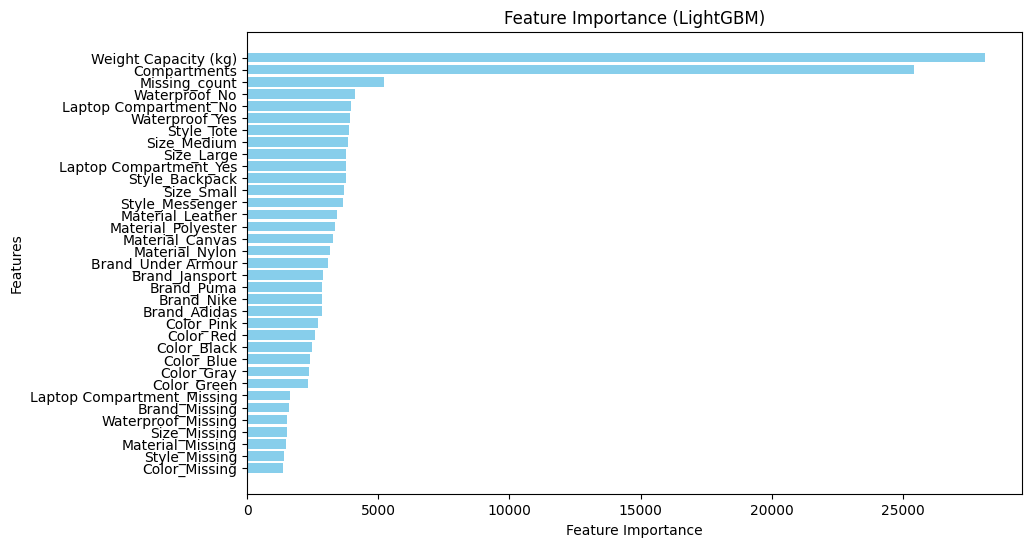

In [17]:
# ------------------------------------------------------- 최적 파라미터로 학습 후 제출 ----------------------------------------

# 최적의 하이퍼파라미터 가져오기
best_params = lgbm_study.best_params
best_params.update({
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'device': 'gpu', 
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'verbose': -1
    })

# 최적의 트리 개수 별도로 가져오기
best_params["n_estimators"] = best_params.pop("num_boost_round", 1022)

# 최적의 파라미터로 최종 모델 학습
lgbm_model = LGBMRegressor(**best_params)
final_lgbm_model = lgbm_model.fit(ce_train_df5, y_df)

# 예측
y_pred = final_lgbm_model.predict(ce_test_df5)

# ------------------------------------------------------ 변수 중요도 추출 및 시각화 ------------------------------------------------------

# 중요도 numpy 배열 생성
feature_importances = final_lgbm_model.feature_importances_

# 데이터프레임 변환
importance_df = pd.DataFrame({
    'Feature': ce_train_df5.columns, 
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

# 제출 파일 생성
lgbm_sub_1 = sub.copy()
lgbm_sub_1['Price'] = y_pred
lgbm_sub_1.to_csv('lgbm_sub_1.csv', index=False)

In [10]:
lgbm_study.best_params

{'learning_rate': 0.07515611287234839,
 'max_depth': 14,
 'num_leaves': 148,
 'min_child_samples': 29,
 'subsample': 0.9698975145499753,
 'colsample_bytree': 0.8563004141958307,
 'reg_alpha': 5.808500513974364,
 'reg_lambda': 3.301304226017915,
 'num_boost_round': 1022}

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(LGBM 시도 2)<br>
결측치 'Missing' 처리<br>
범주형 변수 원-핫 인코딩 처리<br>
하이퍼 파라미터 공간 확장 후 탐색<br>
최대깊이 : (3~15) -> (5,40)
트리개수 : (100~1000) -> (100~2000)
조합탐색 : (100) -> (200)
</div>

In [19]:
%%time

# 인덱스 초기화
ce_train_df5 = ce_train_df5.reset_index(drop = True)
ce_test_df5 = ce_test_df5.reset_index(drop = True)

# 로그 출력 최소화
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 목표함수 정의
def objective(trial):

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 5, 40),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'random_state': 1,
        'device': 'gpu', 
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'verbose': -1
    }

    # 트리 개수 지정 (조기 종료 기능을 위해)
    params["n_estimators"] = trial.suggest_int("n_estimators", 100, 2000)
    
    # 평가척도
    rmse_scores = []

    # 교차검증 객체 생성
    kf = KFold(n_splits = 10, shuffle = True, random_state = 1)

    for train_index, val_index in kf.split(ce_train_df5):
        
        # 학습,검증 데이터 분할
        x_train, x_val = ce_train_df5.iloc[train_index], ce_train_df5.iloc[val_index]
        y_train, y_val = y_df.iloc[train_index], y_df.iloc[val_index]

        lgbm_model = LGBMRegressor(**params, early_stopping_rounds=100)
        lgbm_model.fit(x_train, y_train, eval_set=[(x_val, y_val)])
        y_pred = lgbm_model.predict(x_val)

        rmse = root_mean_squared_error(y_val, y_pred)
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)
    
n_trials = 200
lgbm_study = optuna.create_study(direction = 'minimize')
lgbm_study.optimize(objective, n_trials=n_trials, catch=(Exception,))

        
# 최적 결과 출력
print("\n최고의 RMSE값:", lgbm_study.best_value)
print("최고의 하이퍼파라미터:", lgbm_study.best_params)


최고의 RMSE값: 38.86637241854485
최고의 하이퍼파라미터: {'learning_rate': 0.028060287229888257, 'max_depth': 15, 'num_leaves': 63, 'min_child_samples': 9, 'subsample': 0.923173646638178, 'colsample_bytree': 0.6028667085861046, 'reg_alpha': 3.857496939208297, 'reg_lambda': 4.106702685863463, 'n_estimators': 1871}
CPU times: total: 7d 8min 13s
Wall time: 1d 5h 5min


Feature Importances:
                       Feature  Importance
1         Weight Capacity (kg)       16240
0                 Compartments       13190
2                Missing_count        6653
14                  Size_Large        2952
20      Laptop Compartment_Yes        2926
15                 Size_Medium        2900
22               Waterproof_No        2873
9              Material_Canvas        2849
27                  Style_Tote        2843
24              Style_Backpack        2835
19       Laptop Compartment_No        2833
25             Style_Messenger        2804
23              Waterproof_Yes        2772
13          Material_Polyester        2730
17                  Size_Small        2658
10            Material_Leather        2650
21          Waterproof_Missing        2558
12              Material_Nylon        2540
8           Brand_Under Armour        2502
18  Laptop Compartment_Missing        2481
3                 Brand_Adidas        2378
16                Size_Missing   

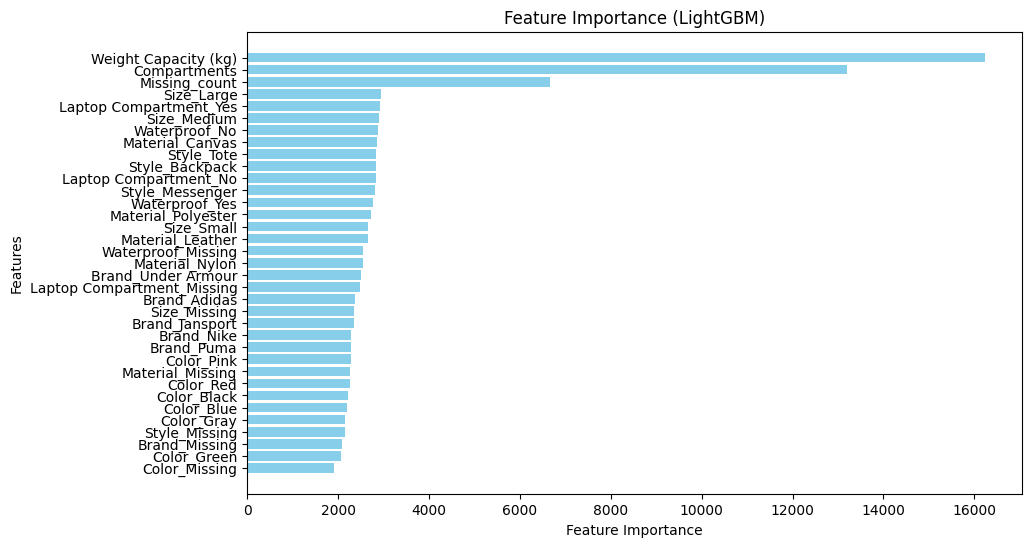

In [21]:
# ------------------------------------------------------- 최적 파라미터로 학습 후 제출 ----------------------------------------


best_params = {
    'learning_rate': 0.028060287229888257,
    'max_depth': 15,
    'num_leaves': 63, 
    'min_child_samples': 9, 
    'subsample': 0.923173646638178, 
    'colsample_bytree': 0.6028667085861046, 
    'reg_alpha': 3.857496939208297, 
    'reg_lambda': 4.106702685863463, 
    'n_estimators': 1871,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'device': 'gpu', 
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'verbose': -1
}

# 최적의 파라미터로 최종 모델 학습
lgbm_model = LGBMRegressor(**best_params)
final_lgbm_model = lgbm_model.fit(ce_train_df5, y_df)

# 예측
y_pred = final_lgbm_model.predict(ce_test_df5)

# ------------------------------------------------------ 변수 중요도 추출 및 시각화 ------------------------------------------------------

# 중요도 numpy 배열 생성
feature_importances = final_lgbm_model.feature_importances_

# 데이터프레임 변환
importance_df = pd.DataFrame({
    'Feature': ce_train_df5.columns, 
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

# 제출 파일 생성
lgbm_sub_2 = sub.copy()
lgbm_sub_2['Price'] = y_pred
lgbm_sub_2.to_csv('lgbm_sub_2.csv', index=False)

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(LGBM 시도 3)<br>
결측치 'Missing' 처리<br>
범주형 변수 원-핫 인코딩 처리<br>
탐색하지 않고 (최대깊이 : 35), (트리개수 : 500) 으로 실행

</div>

Feature Importances:
                       Feature  Importance
1         Weight Capacity (kg)        4438
0                 Compartments        1862
2                Missing_count        1162
16                Size_Missing         794
21          Waterproof_Missing         769
5                Brand_Missing         650
18  Laptop Compartment_Missing         553
28                 Color_Black         366
8           Brand_Under Armour         320
32               Color_Missing         312
3                 Brand_Adidas         307
10            Material_Leather         301
11            Material_Missing         293
26               Style_Missing         287
31                 Color_Green         276
13          Material_Polyester         227
14                  Size_Large         212
30                  Color_Gray         212
29                  Color_Blue         210
34                   Color_Red         208
12              Material_Nylon         188
9              Material_Canvas   

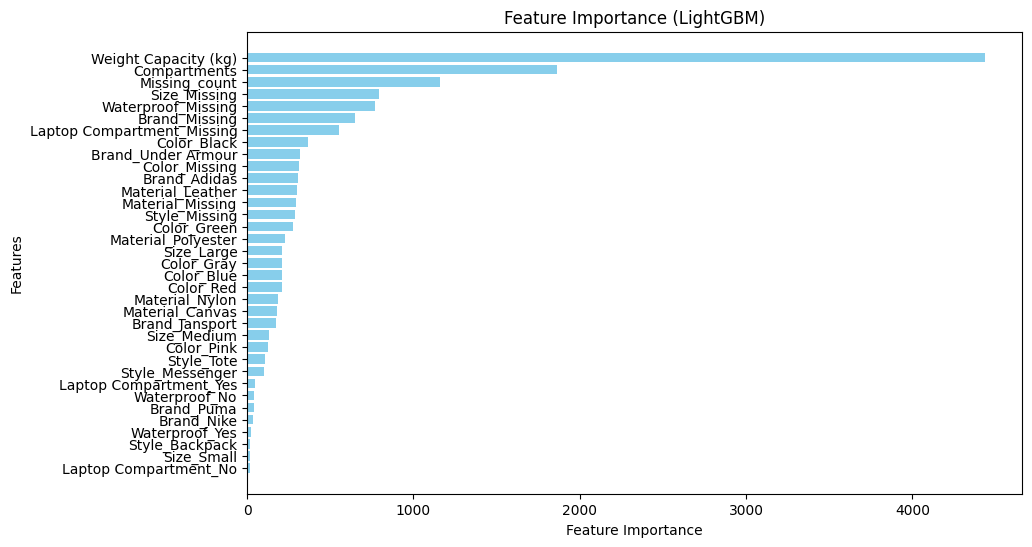

In [ ]:
# ------------------------------------------------------- 최적 파라미터로 학습 후 제출 ----------------------------------------



best_params = {
    'boosting_type' : "gbdt",   
    'objective' : "RMSE",       
    'n_estimators' : 500,       
    'learning_rate' : 0.01,     
    'max_depth' : 35,           
    'device' : "gpu",
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'verbose': -1            
}

# 최적의 파라미터로 최종 모델 학습
lgbm_model = LGBMRegressor(**best_params)
final_lgbm_model = lgbm_model.fit(ce_train_df5, y_df)

# 예측
y_pred = final_lgbm_model.predict(ce_test_df5)

# ------------------------------------------------------ 변수 중요도 추출 및 시각화 ------------------------------------------------------

# 중요도 numpy 배열 생성
feature_importances = final_lgbm_model.feature_importances_

# 데이터프레임 변환
importance_df = pd.DataFrame({
    'Feature': ce_train_df5.columns, 
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

# 제출 파일 생성
lgbm_sub_3 = sub.copy()
lgbm_sub_3['Price'] = y_pred
lgbm_sub_3.to_csv('lgbm_sub_3.csv', index=False)

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(LGBM 시도 4)<br>
결측치 'Missing' 처리<br>
범주형 변수 원-핫 인코딩 처리<br>
탐색하지 않고 (최대깊이 : 35), (트리개수 : 1500) 으로 실행

</div>

Feature Importances:
                       Feature  Importance
1         Weight Capacity (kg)       13853
0                 Compartments        5720
2                Missing_count        2899
16                Size_Missing        1432
21          Waterproof_Missing        1426
5                Brand_Missing        1282
18  Laptop Compartment_Missing        1066
11            Material_Missing         972
8           Brand_Under Armour         851
13          Material_Polyester         835
3                 Brand_Adidas         823
32               Color_Missing         816
34                   Color_Red         746
26               Style_Missing         739
9              Material_Canvas         736
10            Material_Leather         728
28                 Color_Black         719
27                  Style_Tote         651
14                  Size_Large         647
31                 Color_Green         618
24              Style_Backpack         597
29                  Color_Blue   

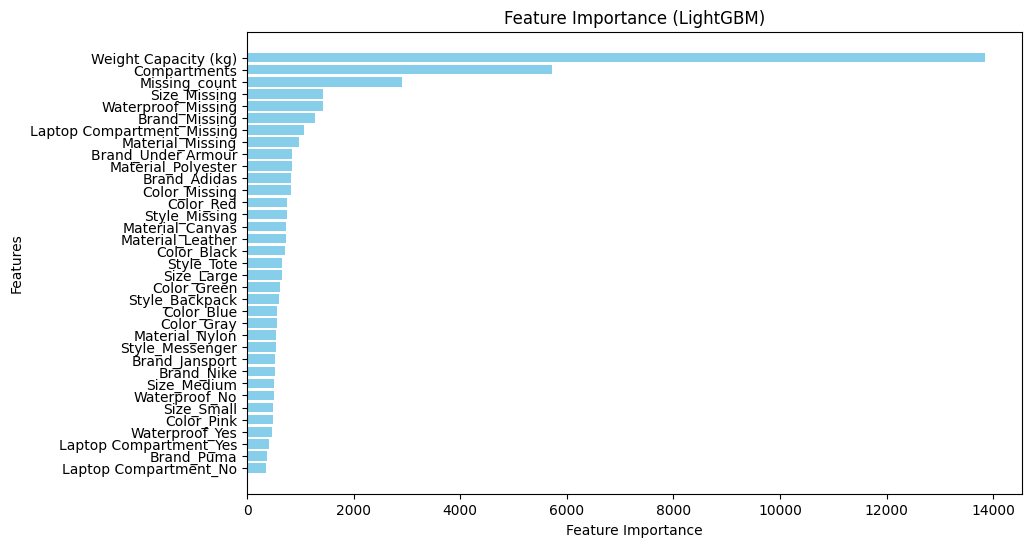

In [5]:
# ------------------------------------------------------- 최적 파라미터로 학습 후 제출 ----------------------------------------

# 인덱스 초기화
ce_train_df5 = ce_train_df5.reset_index(drop = True)
ce_test_df5 = ce_test_df5.reset_index(drop = True)

best_params = {
    'boosting_type' : "gbdt",   
    'objective' : "RMSE",       
    'n_estimators' : 1500,       
    'learning_rate' : 0.01,     
    'max_depth' : 35,           
    'device' : "gpu",
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'verbose': -1            
}

# 최적의 파라미터로 최종 모델 학습
lgbm_model = LGBMRegressor(**best_params)
final_lgbm_model = lgbm_model.fit(ce_train_df5, y_df)

# 예측
y_pred = final_lgbm_model.predict(ce_test_df5)

# ------------------------------------------------------ 변수 중요도 추출 및 시각화 ------------------------------------------------------

# 중요도 numpy 배열 생성
feature_importances = final_lgbm_model.feature_importances_

# 데이터프레임 변환
importance_df = pd.DataFrame({
    'Feature': ce_train_df5.columns, 
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

# 제출 파일 생성
lgbm_sub_4 = sub.copy()
lgbm_sub_4['Price'] = y_pred
lgbm_sub_4.to_csv('lgbm_sub_4.csv', index=False)

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(LGBM 시도 5)<br>
모든 변수 타겟인코딩한 데이터 프레임<br>
</div>

In [3]:
%%time

te_train_df = pd.read_csv('te_train_df')
te_test_df = pd.read_csv('te_test_df')

te_train_df = te_train_df.reset_index()
te_test_df = te_test_df.reset_index()

optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'n_estimators' : trial.suggest_int("n_estimators", 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 5, 35),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 1,
        'device': 'gpu', 
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'verbose': -1
    }

    kf = KFold(n_splits = 5, shuffle= True, random_state= 1)

    rmse_scores = []

    for train_index, val_index in kf.split(te_train_df):
        x_train, x_val = te_train_df.iloc[train_index], te_train_df.iloc[val_index]
        y_train, y_val = y_df.iloc[train_index], y_df.iloc[val_index]

        lgbm_model = LGBMRegressor(**params, early_stopping_rounds=100)
        lgbm_model.fit(x_train, y_train, eval_set=[(x_val, y_val)])
        
        y_pred = lgbm_model.predict(x_val)

        rmse = root_mean_squared_error(y_val, y_pred)

        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

n_trials = 200
lgbm_study = optuna.create_study(direction = 'minimize')
lgbm_study.optimize(objective, n_trials=n_trials, catch=Exception)
       
# 최적 결과 출력
print("\n최고의 RMSE값:", lgbm_study.best_value)
print("최고의 하이퍼파라미터:", lgbm_study.best_params)


최고의 RMSE값: 38.69953023456226
최고의 하이퍼파라미터: {'n_estimators': 1610, 'learning_rate': 0.010778996386807065, 'max_depth': 16, 'num_leaves': 60, 'min_child_samples': 10, 'subsample': 0.9878765234269894, 'colsample_bytree': 0.6686529815076371}
CPU times: total: 3d 1h 15min 9s
Wall time: 12h 30min 48s


Feature Importances:
                    Feature  Importance
0                     index       12202
9   Weight Capacity (kg)_TE       11958
4           Compartments_TE       10361
8                  Color_TE       10022
1                  Brand_TE        9863
2               Material_TE        8802
3                   Size_TE        7883
7                  Style_TE        7675
6             Waterproof_TE        6745
5     Laptop Compartment_TE        6729
10            Missing_count        2750


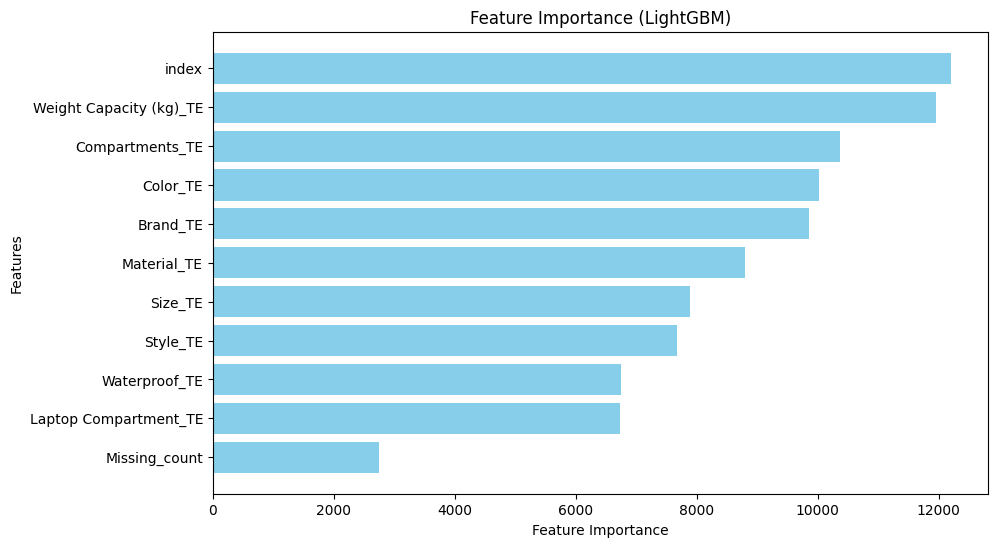

In [4]:
# ------------------------------------------------------- 최적 파라미터로 학습 후 제출 ----------------------------------------



best_params = lgbm_study.best_params
best_params.update({
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'device': 'gpu', 
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'verbose': -1
    })


# 최적의 파라미터로 최종 모델 학습
lgbm_model = LGBMRegressor(**best_params)
final_lgbm_model = lgbm_model.fit(te_train_df, y_df)

# 예측
y_pred = final_lgbm_model.predict(te_test_df)

# ------------------------------------------------------ 변수 중요도 추출 및 시각화 ------------------------------------------------------

# 중요도 numpy 배열 생성
feature_importances = final_lgbm_model.feature_importances_

# 데이터프레임 변환
importance_df = pd.DataFrame({
    'Feature': te_train_df.columns, 
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

# 제출 파일 생성
lgbm_sub5 = sub.copy()
lgbm_sub5['Price'] = y_pred
lgbm_sub5.to_csv('lgbm_sub5.csv', index=False)

<div style="background-color:red; padding:10px; border-radius:10px; font-size:18px;">
(LGBM 시도 6)<br>
시도 5에서 실수로 인덱스 열을 포함하고 학습했는데 높은 변수 중요도가 나왔다<br>
인덱스 열을 제거하고 다시 학습해본다
</div>

In [4]:
%%time

te_train_df = pd.read_csv('te_train_df')
te_test_df = pd.read_csv('te_test_df')

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# 학습과정 로그 출력 활성화
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'n_estimators' : trial.suggest_int("n_estimators", 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 5, 35),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 1,
        'device': 'gpu', 
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'verbose': -1
    }

    kf = KFold(n_splits = 5, shuffle= True, random_state= 1)

    rmse_scores = []

    for train_index, val_index in kf.split(te_train_df):
        x_train, x_val = te_train_df.iloc[train_index], te_train_df.iloc[val_index]
        y_train, y_val = y_df.iloc[train_index], y_df.iloc[val_index]

        lgbm_model = LGBMRegressor(**params, early_stopping_rounds=100)
        lgbm_model.fit(x_train, y_train, eval_set=[(x_val, y_val)])
        
        y_pred = lgbm_model.predict(x_val)

        rmse = root_mean_squared_error(y_val, y_pred)

        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

n_trials = 200
lgbm_study = optuna.create_study(direction = 'minimize')
lgbm_study.optimize(objective, n_trials=n_trials, catch=Exception)
       
# 최적 결과 출력
print("\n최고의 RMSE값:", lgbm_study.best_value)
print("최고의 하이퍼파라미터:", lgbm_study.best_params)

[I 2025-02-25 00:10:56,330] A new study created in memory with name: no-name-10f4ea17-03f4-42c3-a30f-07ed6aeed819
[I 2025-02-25 00:11:48,825] Trial 0 finished with value: 38.70821886338479 and parameters: {'n_estimators': 1443, 'learning_rate': 0.3454889263186155, 'max_depth': 14, 'num_leaves': 137, 'min_child_samples': 15, 'subsample': 0.8451088439263612, 'colsample_bytree': 0.7858353106758902}. Best is trial 0 with value: 38.70821886338479.
[I 2025-02-25 00:12:24,456] Trial 1 finished with value: 38.70696777104335 and parameters: {'n_estimators': 1972, 'learning_rate': 0.559779195343869, 'max_depth': 26, 'num_leaves': 41, 'min_child_samples': 39, 'subsample': 0.8214714937540147, 'colsample_bytree': 0.5301790544597429}. Best is trial 1 with value: 38.70696777104335.
[I 2025-02-25 00:14:10,969] Trial 2 finished with value: 38.70120477957993 and parameters: {'n_estimators': 1595, 'learning_rate': 0.09583078911672317, 'max_depth': 7, 'num_leaves': 79, 'min_child_samples': 37, 'subsample'

KeyboardInterrupt: 

In [5]:
# 최적 결과 출력
print("\n최고의 RMSE값:", lgbm_study.best_value)
print("최고의 하이퍼파라미터:", lgbm_study.best_params)


최고의 RMSE값: 38.69884379908668
최고의 하이퍼파라미터: {'n_estimators': 1600, 'learning_rate': 0.010167192273339537, 'max_depth': 26, 'num_leaves': 50, 'min_child_samples': 23, 'subsample': 0.7300423901858772, 'colsample_bytree': 0.5795554655295079}


Feature Importances:
                   Feature  Importance
8  Weight Capacity (kg)_TE       11425
3          Compartments_TE       10053
7                 Color_TE        9320
0                 Brand_TE        9318
1              Material_TE        8141
2                  Size_TE        7631
6                 Style_TE        7140
5            Waterproof_TE        6356
4    Laptop Compartment_TE        6207
9            Missing_count        2809


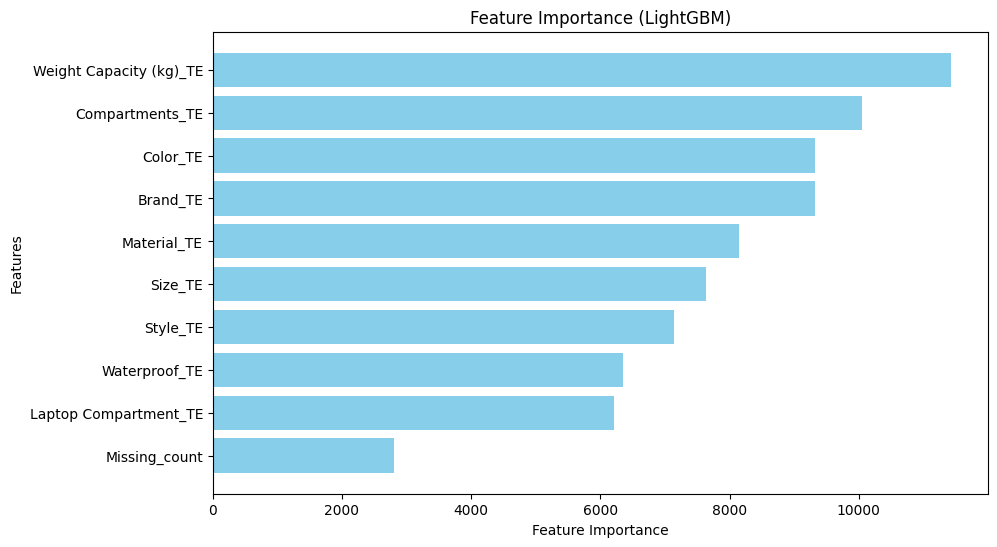

In [6]:
# ------------------------------------------------------- 최적 파라미터로 학습 후 제출 ----------------------------------------



best_params = lgbm_study.best_params
best_params.update({
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'device': 'gpu', 
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'verbose': -1
    })


# 최적의 파라미터로 최종 모델 학습
lgbm_model = LGBMRegressor(**best_params)
final_lgbm_model = lgbm_model.fit(te_train_df, y_df)

# 예측
y_pred = final_lgbm_model.predict(te_test_df)

# ------------------------------------------------------ 변수 중요도 추출 및 시각화 ------------------------------------------------------

# 중요도 numpy 배열 생성
feature_importances = final_lgbm_model.feature_importances_

# 데이터프레임 변환
importance_df = pd.DataFrame({
    'Feature': te_train_df.columns, 
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print("Feature Importances:")
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 표시
plt.show()

# ----------------------------------------------------------- 제출 파일 -----------------------------------------------------------------

# 제출 파일 생성
lgbm_sub6 = sub.copy()
lgbm_sub6['Price'] = y_pred
lgbm_sub6.to_csv('lgbm_sub6.csv', index=False)